# Notatki do pracowni drugiej

In [1]:
using PyPlot
include("program.jl")
c = 299792.458
earth_rad = 6370.0
sat_rad = 20000.0;

## Metoda najmniejszych kwadratów

Mamy układ równań
$$ (x-x_{i})^2 + (y - y_{i})^2 + (z - z_{i})^2 - \big[c(t_{i}-t)\big]^2 = 0 \ , \ i =  1, 2 \ ... \ n \ , \ n > 4$$
Niech
$$ f_{i}(x, y, z, t) = (x-x_{i})^2 + (y - y_{i})^2 + (z - z_{i})^2 - \big[c(t_{i}-t)\big]^2 $$
Chcemy znaleźć takie $(x, y, z, t)$, że
$$\sum_{1}^{n} f_{i}^2(x, y, z, t) $$ 
będzie minimalne.

Zastosujemy metodę będącą uogólnieniem metody Newtona opisanej powyżej:
Niech:
$$ h_{n} = -(J_{n}^T J_{n})^{-1} J^T F(x_{n})$$
gdzie

$J_{n}$ - macierz pochodnych cząstkowych w punkcie $x_n$ 

$J_{n}[i, j] = \frac{\partial f_i}{\partial x_j} $

$F(x) \in R^4 \to R^n , F(x) = \big[f_{i}(x)\big]$

Wtedy
$$ x_{n+1} = x_{n} + h_{n} $$
Jest n-tym przybliżeniem metody.

In [3]:
function leastSquares(sats, maxiter=20, satcnt=8)
    newton(sats[1:satcnt], maxiter)
end;

# Testy

In [ ]:
sat = Array{Array{Float64}}(7)

sat[1] = [15600.0, 7540.0, 20140.0, 7.074e-2]
sat[2] = [18760.0, 2750.0, 18610.0, 7.220e-2]
sat[3] = [17610.0, 14630.0, 13480.0, 7.690e-2]
sat[4] = [19170.0, 610.0, 18390.0, 7.242e-2]
sat[5] = rand_position(sat_rad)
sat[6] = rand_position(sat_rad)
sat[7] = rand_position(sat_rad)

x = rand_position(earth_rad)
prepsat!(x, sat)

println(x)
println(newton(sat))
println(algebraic(sat))
println(bancroft(sat))
println(heura(sat))

Będziemy sprawdzać dokładność metod za pomocą symulacji trasy obiektu na powierzchni Ziemi oraz pozycji satelit. Znając rzeczywiste położenie satelity, obiektu i błędu zegara wyliczamy stałe $t_{i}$. Następnie stosujemy każdą z metod do wyliczenia położenia obiektu.

Aby wzbogacić symulację, dodany został współczynnik $inacuraccy$ mający na celu odwzorować zmiany prędkości światła ośrodkach innych niż próżnia.

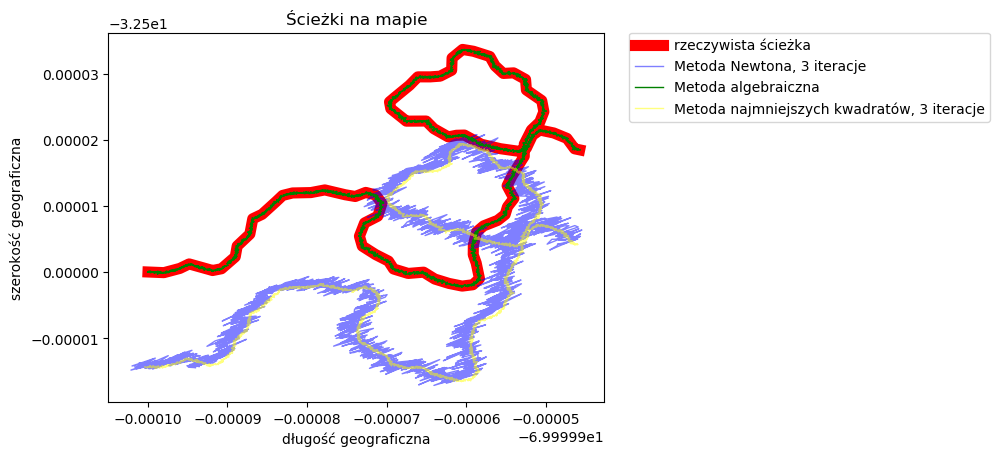

HTML{String}("<table border=\"1\">\n<tr><td><pre>Metoda</pre><td><pre>Największy błąd</pre><td><pre>Najmniejszy błąd</pre></tr><tr><td><pre>Newtona, 3 iteracje</pre><td><pre>1.765113441817653</pre><td><pre>1.38735006191103</pre></tr><tr><td><pre>Najmnieszych kwadratów, 3 iteracje</pre><td><pre>1.6253896668988888</pre><td><pre>1.5619360258090529</pre></tr><tr><td><pre>Algebraiczna</pre><td><pre>0.04454710380548603</pre><td><pre>0.00032323083347402806</pre></tr><tr><td><pre>Bancrofta</pre><td><pre>0.047973108736300986</pre><td><pre>0.00024837269050145887</pre></tr></table>")

In [6]:
sat_count = 8
sat_coords = [ rand_position(sat_rad)[1:3] for i = 1:sat_count ]

coords = path(3000, -70, -32.5)
x = coords[1]
y = coords[2]

mistake = 0.005

newton_coords = GPS_newton(coords, mistake, 3, true)
xn = newton_coords[1]
yn = newton_coords[2]

leastSquares_coords = GPS_leastSquares(coords, mistake, 3, sat_count, true)
xl = leastSquares_coords[1]
yl = leastSquares_coords[2]

alg_coords = GPS_alg(coords, mistake, true)
xa = alg_coords[1]
ya = alg_coords[2]

bancroft_coords = GPS_bancroft(coords, mistake, true)
xb = bancroft_coords[1]
yb = bancroft_coords[2]

fig, ax = subplots()

title("Ścieżki na mapie")
xlabel("długość geograficzna")
ylabel("szerokość geograficzna")
ax[:plot](x, y, "-", color="red", linewidth=8, alpha=1.0, label="rzeczywista ścieżka")
ax[:plot](xn, yn, "-", color="blue", linewidth=1, alpha=0.5, label="Metoda Newtona (3 iteracje)")
ax[:plot](xa, ya, "-", color="green", linewidth=1, alpha=1.0, label="Metoda algebraiczna")
ax[:plot](xl, yl, "-", color="yellow", linewidth=1, alpha=0.5, label="Metoda najmniejszych kwadratów (3 iteracje)")
ax[:legend](bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
show()

methods =["Newtona, 3 iteracje", "Najmnieszych kwadratów, 3 iteracje", "Algebraiczna", "Bancrofta"]
results = [newton_coords, leastSquares_coords, alg_coords, bancroft_coords]

MinMaxMistakeTable(methods, results, coords)

In [ ]:
function clock_mistake_plot(method, coords, maxiter)
    res = [[], []]
    dm = 0.1
    mistake = 0.0
    for i in 1:maxiter
        alg_coords = method(coords, mistake)
        dist = MAXdist(coords, alg_coords)
        push!(res[1], mistake)
        push!(res[2], dist)
        mistake+=dm
    end
    res
end;

Istotnym czynnikiem wpływającym na niedokładność pomiaru jest błąd zegara.

In [ ]:
data1 = clock_mistake_plot(GPS_alg, coords, 10)
x = data1[1]
y1 = data1[2]

data2 = clock_mistake_plot(GPS_newton, coords, 10)
y2 = data2[2]

data3 = clock_mistake_plot(GPS_heura, coords, 10)
y3 = data3[2]

data4 = clock_mistake_plot(GPS_bancroft, coords, 10)
y4 = data4[2]

data5 = clock_mistake_plot(GPS_leastSquares, coords, 10)
y5 =  data5[2]

fig, ax = subplots()

title("Błąd metod w zależności od błędu zegara")
ylabel("m")
xlabel("s")
ax[:plot](x, y1, "-", color="green", linewidth=2, alpha=1.0, label="Metoda algebraiczna")
ax[:plot](x, y2, "-", color="blue", linewidth=2, alpha=1.0, label="Metoda Newtona")
ax[:plot](x, y3, "-", color="red", linewidth=2, alpha=1.0, label="Heura")
ax[:plot](x, y4, "-", color="yellow", linewidth=2, alpha=1.0, label="Metoda Bancrofta")
ax[:plot](x, y5, "-", color="black", linewidth=2, alpha=1.0, label="Metoda najmniejszych kwadratów")
ax[:legend](bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

show()

W metodach Newtona oraz najmniejszych kwadratów dokładność powinna zwiększać się wraz z liczbą iteracji. Można udowodnić, że powinna to być zbieżność kwadratowa. 

In [ ]:
function iter_mistake_plot(method, coords, maxiter)
    res = [[], []]
    for i in 1:maxiter
        newton_coords = method(coords, 0.005, i)
        dist = MAXdist(coords, newton_coords)
        push!(res[1], i)
        push!(res[2], dist)
    end
    return res
end
show()

In [ ]:
data1 = iter_mistake_plot(GPS_newton, coords, 10)
x = data1[1]
y1 = data1[2]

data2 = iter_mistake_plot(GPS_leastSquares, coords, 10)
y2 = data2[2]

tab = hcat(x, y1, y2)

table(tab, column_names=[:"Iteracja", :"Błąd metody Newtona (m)", :"Błąd metody najmniejszych kwadratów (m)"])

Poniżej sprawdzamy dokładność pomiarów dla losowych punktów na Ziemi

In [ ]:
sat_count = 10
sat = Array{Array{Float64}}(sat_count)

mean1 = 0
mean2 = 0
mean3 = 0
mean4 = 0
mean5 = 0

iters = 5000

for i = 1:iters
    sat = [ rand_position(sat_rad) for j = 1:sat_count ]
    x = rand_position(earth_rad)
    #LL = XYZtoLLA(x)
    #mistake = 0.00001
    #sat =  createSats(LL[1], LL[2], mistake)
    prepsat!(x, sat)
    x1 = newton(sat[1:4])
    x2 = algebraic(sat)
    x3 = bancroft(sat)
    x4 = heura(sat)
    x5 = leastSquares(sat)

    mean1 += sum(abs2, x1 - x)
    mean2 += sum(abs2, x2 - x)
    mean3 += sum(abs2, x3 - x)
    mean4 += sum(abs2, x4 - x)
    mean5 += sum(abs2, x5 - x)
end

mean1 /= iters
mean2 /= iters
mean3 /= iters
mean4 /= iters
mean5 /= iters

names = ["Newton", "Algebraiczna", "Bancroft", "Heura", "Najmniejszych kwadratów"]
results = [mean1, mean2, mean3, mean4, mean5]

table(hcat(names, results), column_names=[:Metoda, :"Średni błąd (m)"])

Wpływ liczby satelit na dokładność metody najmniejszych kwadratów

In [ ]:
function leastSquares_sat_plot(positers=100, satiters=50)
    res = [[],[]]
    
    sat = [ rand_position(sat_rad) for i in 1:satiters ]
    means = zeros(satiters)

    for i in 1:positers
        x = rand_position(earth_rad)
        prepsat!(x, sat)
        for sat_cnt in 4:satiters
            xgps = leastSquares(sat, 10, sat_cnt)
            means[sat_cnt] += sum(abs2, xgps-x)
        end
    end
    for i in 4:satiters
        push!(res[1], i)
        push!(res[2], means[i]/positers)
    end
    res
end;

In [ ]:
data = leastSquares_sat_plot()
x = data[1]
y = data[2]

fig, ax = subplots()

title("Błąd metody najmniejszych kwadratów w zależności od liczby satelit")
ylabel("m")
xlabel("liczba satelit")
ax[:plot](x, y, "-", color="red", linewidth=2, alpha=1.0)
show()